## Alex Notebook, EDA & Wahrscheinlichkeitsrechnen

Import modules

In [3]:
# import the modules
import pandas as pd
from influxdb import DataFrameClient, InfluxDBClient
import pytz
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from fhnw_ds_hs2019_weatherstation_api import data_import as weather

import config as cfg
import Import_Data_API as ImpData

Define df client for Pandas

In [4]:
client = cfg.client

Data exploration

In [7]:
#Set time relative to now for Query (today: 00:00:00)
now = datetime.datetime.today()
past = now - datetime.timedelta(days = cfg.days_delta)

#Set start and end time
end_time = now.strftime("%Y-%m-%d %H:%M:%S")
start_time = past.strftime("%Y-%m-%d %H:%M:%S")

# NoSQL Query
query = "SELECT * FROM \"{}\",\"{}\" WHERE time >= '{}' AND time <= '{}' "\
                        .format(cfg.stations[0], cfg.stations[1], start_time, end_time)

df_temp = client.query(query)

mythenquai_1year = pd.DataFrame(df_temp['mythenquai'])
tiefenbrunnen_1year = pd.DataFrame(df_temp['tiefenbrunnen'])

mythenquai_1year.info()
tiefenbrunnen_1year.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52495 entries, 2019-01-09 00:40:00+00:00 to 2020-01-08 23:00:00+00:00
Data columns (total 12 columns):
air_temperature            52495 non-null float64
barometric_pressure_qfe    52495 non-null float64
dew_point                  52495 non-null float64
global_radiation           52495 non-null int64
humidity                   52495 non-null int64
precipitation              52495 non-null int64
water_temperature          52495 non-null float64
wind_direction             52495 non-null int64
wind_force_avg_10min       52495 non-null int64
wind_gust_max_10min        52495 non-null float64
wind_speed_avg_10min       52495 non-null float64
windchill                  52495 non-null float64
dtypes: float64(7), int64(5)
memory usage: 5.2 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52527 entries, 2019-01-09 00:40:00+00:00 to 2020-01-08 23:00:00+00:00
Data columns (total 10 columns):
air_temperature            52527 non-null float6

#### Functions

In [12]:
def rowindex_as_col(df):
    """add row index(time) to new column. df = dataframe, name_col = new column name"""
    df.index.name = "time"
    df = df.reset_index(inplace = False)
    df = pd.DataFrame(df)
    return df

In [13]:
def appropriate_dtypes(df, column_name, result_dtype ):
    """Datentypen ändern"""
    df = df.astype({column_name: result_dtype})
    return df

### Correlation

In [33]:
df1, df2 = ImpData.select_timedelta(0,7)

In [45]:
print(df1.equals(df2)) #control if have same number of variables
print(df1.corrwith(df2)) #observe correlation of data between two dataframes

False
air_temperature            0.981087
barometric_pressure_qfe    0.999449
dew_point                  0.969302
humidity                   0.928731
water_temperature          0.777560
wind_direction             0.169739
wind_force_avg_10min       0.431151
wind_gust_max_10min        0.729478
wind_speed_avg_10min       0.498546
windchill                  0.876091
global_radiation                NaN
precipitation                   NaN
dtype: float64


Alle Daten ausser den Winddaten sehen sich ziemlich ähnlich. Es wäre somit sinnvoll die Winddaten für beide Stationen grafisch für die Segler darzustellen. Alle die anderen Daten mit einer Korrelation von über 90% können von einer Station übernommen werden.

#### Query Data from InfluxDB

In [10]:
mythenquai_, tiefenbrunnen_ = ImpData.select_timedelta(0, 100)

#### Transform Data

In [14]:
mythenquai_ = appropriate_dtypes(mythenquai_, "humidity" , np.int8)
tiefenbrunnen_ = appropriate_dtypes(tiefenbrunnen_, "wind_direction", np.int16)

In [15]:
mythenquai_ = appropriate_dtypes(mythenquai_, "humidity", np.int8)
mythenquai_ = appropriate_dtypes(mythenquai_,"wind_direction", np.int16 )

### Exploratory Data Analysis

Aesthetische Einstellungen:

In [16]:
sns.set_style("darkgrid")
sns.set_palette("Paired")

In [17]:
round(tiefenbrunnen_.describe(),1)

,air_temperature,barometric_pressure_qfe,dew_point,humidity,water_temperature,wind_direction,wind_force_avg_10min,wind_gust_max_10min,wind_speed_avg_10min,windchill
count,14376.0,14376.0,14376.0,14376.0,14376.0,14376.0,14376.0,14376.0,14376.0,14376.0
mean,8.0,966.5,5.3,84.2,11.6,127.8,0.9,2.5,1.0,7.3
std,4.7,10.1,4.3,9.6,3.8,114.6,1.1,3.0,1.5,4.8
min,-1.7,934.2,-4.6,45.0,6.6,0.0,0.0,0.0,0.0,-4.0
25%,4.6,960.2,2.1,78.0,7.9,9.0,0.0,0.1,0.0,3.8
50%,7.5,967.2,4.8,85.0,10.9,114.0,1.0,1.6,0.3,6.5
75%,11.6,973.1,8.5,92.0,15.3,190.2,1.0,3.3,1.4,10.9
max,21.1,988.6,15.5,100.0,70.0,360.0,5.0,24.0,10.4,21.1


In [18]:
round(mythenquai_.describe(),1)

,air_temperature,barometric_pressure_qfe,dew_point,global_radiation,humidity,precipitation,water_temperature,wind_direction,wind_force_avg_10min,wind_gust_max_10min,wind_speed_avg_10min,windchill
count,14338.0,14338.0,14338.0,14338.0,14338.0,14338.0,14338.0,14338.0,14338.0,14338.0,14338.0,14338.0
mean,7.8,966.4,5.3,52.9,84.9,0.0,11.5,183.5,1.8,4.0,2.1,6.5
std,4.8,10.1,4.3,109.9,10.0,0.1,3.7,110.9,0.7,2.5,1.2,5.1
min,-1.6,934.1,-5.6,0.0,40.0,0.0,6.1,0.0,0.0,0.0,0.0,-5.8
25%,4.4,960.1,2.0,0.0,79.0,0.0,7.8,85.0,1.0,2.2,1.3,2.6
50%,7.3,967.1,4.7,0.0,87.0,0.0,10.8,168.0,2.0,3.3,1.9,5.8
75%,11.2,973.0,8.5,54.0,93.0,0.0,15.4,297.0,2.0,4.9,2.7,10.2
max,23.4,988.5,16.0,715.0,100.0,2.0,18.5,360.0,5.0,21.8,8.6,22.2


Korrelationen Bereich Temperatur und Feuchte:

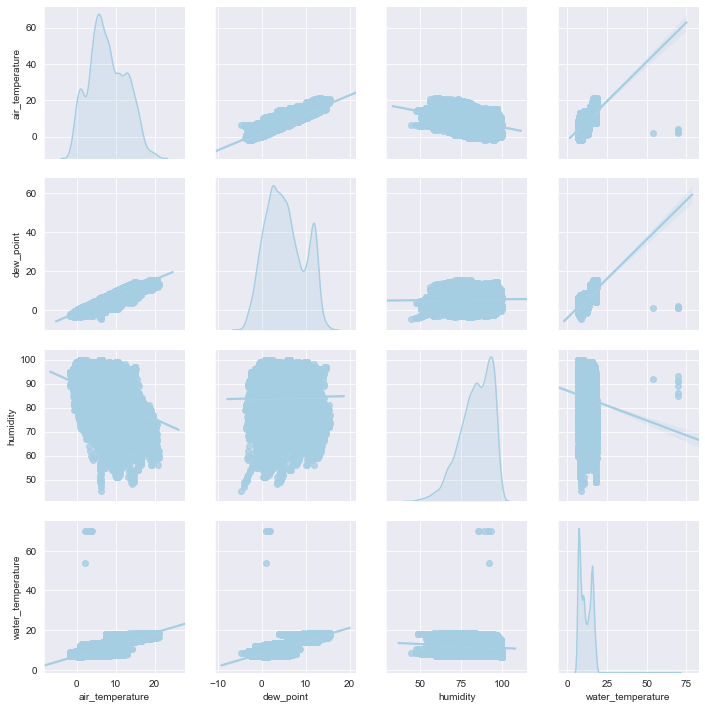

In [19]:
tiefenbrunnen_adapt_temp = tiefenbrunnen_.drop( columns = ["wind_direction","wind_force_avg_10min",
                                                             "wind_gust_max_10min","wind_speed_avg_10min",
                                                             "windchill", "barometric_pressure_qfe"])
tiefenbrunnen_adapt_temp = rowindex_as_col(tiefenbrunnen_adapt_temp)
tiefenbrunnen_adapt_temp.head()
sns.pairplot(tiefenbrunnen_adapt_temp, kind = "reg", diag_kind = "kde")

#### Auffälligkeiten:
- Starke Negative Korrelation zwischen Luftfeuchte und Temperatur
- Eigentlich sollte der Taupunkt bei 100% relativer Luftfeuchte sein. Erklärung?
- Es bestehen positive Korrelationen zwischen Lufttemperatur, Wassertemperatur und Taupunkt.
- Negative Korrelationen zwischen Lufttemperatur und Luftfeuchtigkeit.

#### Bemerkungen
- Barometrischer Druck entfernt, da schwache Korrelationen

Korrelationen Bereich Wind:

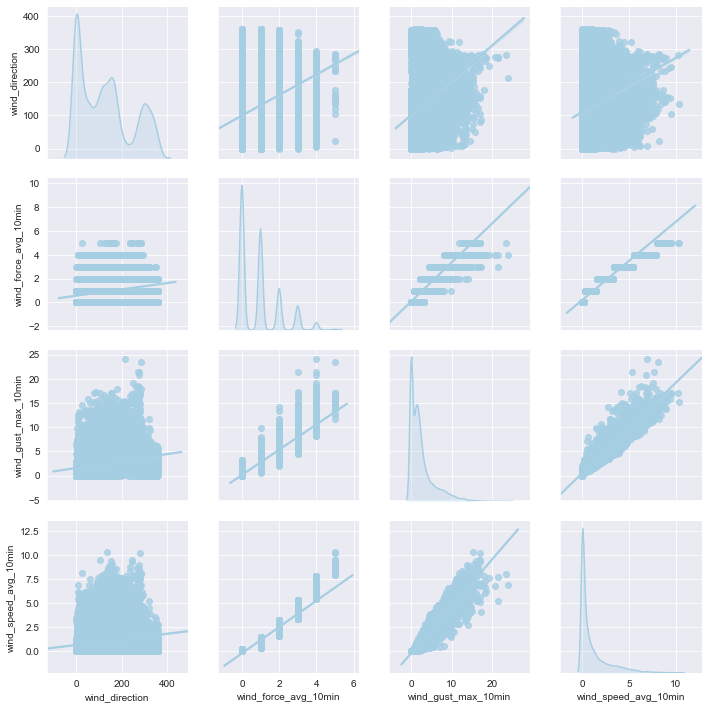

In [20]:
tiefenbrunnen_adapt_wind = tiefenbrunnen_.drop( columns = ["air_temperature","barometric_pressure_qfe","dew_point",
                                                             "humidity", "water_temperature", "windchill"])
sns.pairplot(tiefenbrunnen_adapt_wind, kind = "reg", diag_kind = "kde")

#### Auffällligkeiten:
- Positive Korrelation zwischen Windrichtung, Geschwindigkeiten und WIndstärke
- Starke Positive Korrelation zwischen Windgeschwindigkeit, Stärke

### Prognose
Als Referenz werden die Temperaturdaten aus dem Jahr 2018 genommen

In [47]:
path_2_file = "./influxdb-1.7.8-1/data/messwerte_mythenquai_2007-2018.csv"
df_prediction = pd.read_csv(path_2_file, index_col=0)
#df_prediction.head()

,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,dew_point,global_radiation,humidity,water_level
timestamp_cet,,,,,,,,,,,,,
2007-04-22T21:20:00,18.9,15.2,1.6,0.7,0.7,321,18.9,973.5,0.0,4.4,3,38,405.94
2007-04-22T21:30:00,18.1,15.2,1.3,0.8,0.8,346,18.1,973.7,0.0,4.8,3,41,405.94
2007-04-22T21:40:00,17.7,15.1,0.9,0.2,0.2,4,17.7,973.7,0.0,5.1,3,43,405.94
2007-04-22T21:50:00,17.6,15.3,0.6,0.1,0.1,235,17.6,973.8,0.0,5.7,3,45,405.94
2007-04-22T22:00:00,17.4,15.4,0.7,0.3,0.3,178,17.4,973.9,0.0,6.3,3,48,405.94


In [48]:
df_pred = df_prediction
df_pred.index = pd.to_datetime(df_pred.index)

df_pred = df_pred.loc["2018-01-01":"2018-12-31"]

len(df_pred)

52213

#### Verfahren mit Kolmogorov-Smirnoff Test:    

Es werden Daten von zwei Jahren in zwei Tage gruppiert. Die gruppierten Daten werden dann mit
dem aktuellen "ganzen" Tag verglichen und geben dann die Temperatur für den nachfolgenden Tag aus.

In [49]:
def get_values_in_grouped_days(df, column, group_string, group_int):
    """ 
    Splits distributions in separate lists of days together as new list of values. This DF is always used as reference to determine temperature of next day.
    Input: df = vector or dataframe, column = specific column index, group_string = "3D", "D", group_int = integer days want to group
    """ 
    
    df.index = pd.to_datetime(df.index) ## Index conversion to datetime
    day_shift = -1

    df1 = df.iloc[:, column]
    
    grouped_df = df1.resample(group_string).aggregate(lambda tdf: tdf.tolist()) #Creates new df by grouping days
    grouped_df = pd.DataFrame(grouped_df)
    
    df2 = df.iloc[:, column]
    
    grouped_df_max = df2.resample("D").aggregate(lambda tdf: tdf.max())
    grouped_df_max = pd.DataFrame(grouped_df_max)
    grouped_df_max = grouped_df_max[::group_int].iloc[1:] ## takes each third row and drops the first one

    new_df = pd.concat([grouped_df, grouped_df_max], axis = 1)
    new_df = new_df.shift(day_shift).dropna() 
    new_df.columns = ["grouped_values", "Temp_next_day"]
    
    return new_df
     

In [25]:
sample_df = get_values_in_grouped_days(df_pred, 0, "1D", 1)
sample_df.head()

,grouped_values,Temp_next_day
timestamp_cet,,
2018-01-01,"[5.9, 5.8, 5.6, 5.5, 5.2, 5.0, 5.1, 5.1, 5.1, ...",7.4
2018-01-02,"[4.1, 4.1, 4.1, 4.0, 4.1, 4.1, 3.9, 3.9, 3.9, ...",14.5
2018-01-03,"[6.0, 6.3, 6.3, 5.8, 5.6, 5.6, 5.7, 6.0, 6.1, ...",13.7
2018-01-04,"[12.4, 12.5, 12.4, 12.3, 12.2, 12.0, 11.9, 11....",13.0
2018-01-05,"[8.5, 8.5, 8.1, 7.6, 7.5, 7.5, 7.5, 7.3, 7.3, ...",8.5


In [26]:
#df_max = df_prediction.loc["2010-08-02":"2018-08-02"].max()

df_test = df_prediction.loc["2010-01-01":"2017-12-31"]
df_test = df_test.iloc[:,0]
df_test = pd.DataFrame(df_test)

df_test2 = df_prediction.loc["2018-01-11":"2018-01-12"]

#df_test = df_test.reset_index(drop = True)
#df_test.head()
#df_test2
#df_max

### Vorhersage mit KS-Test

In [27]:
from scipy import stats as spstats

def prediction_ks_test(df_for_test, sample_df):
    """Predicts the value of next day by using the statistical KS-Test of Scipy package. It's used to compare the distributions of two
    test samples. The higher the probability value the better is the fit.
    Input: df_for_test: dataframe of one day to perform the test / sample_df: specific sample df as reference
    Returns: fitting maximum temperature of next day
    """
    KS_p_val_to_compare = 0
    fitting_temp_next_day = 0
    iterations = 0 ## length not equal of sample df 
        
    for row in range(0, len(sample_df)):
                                
        KS_stat, KS_p_val = spstats.ks_2samp(df_for_test.iloc[:, 0], sample_df.iloc[row, 0]) # Perform t-test
          
        if KS_p_val > KS_p_val_to_compare:
            KS_p_val_to_compare = KS_p_val
            fitting_temp_next_day = sample_df.iloc[row, 1]
            
        iterations = iterations + 1        
            
    #print("P-Wert: {} / Iterations: {} / Fitting Temp.: {}".format(KS_p_val_to_compare, iterations, fitting_temp_next_day))                                                                                                                            
    
    return fitting_temp_next_day
     

#### Performance Kolmogorov-Smirnoff:
Der Durchschnitt aller Messwerte aus einem Jahr.


In [28]:
def prediction_test_KS(df_test, sample_df, days_used_for_prediction):
    """Purpose is to test a generated prediction method of one year. Calculates the average deviation of one simulative test year
    Parameters: df_test = df which should be tested(first column) / days_used_... = 1d (how much days're used for the prediction)
    """
    days_offset = days_used_for_prediction         
    start_date_str = "2015-01-01" ## Check all Values for this year
    start_date = datetime.datetime.strptime(start_date_str,  "%Y-%m-%d")
    days_in_df_test = len(df_test.index.dayofyear.unique())
    
    test_results = np.array([])
    
    for day in range(days_used_for_prediction, days_in_df_test):
        ## Maximum Temperature of +1day or how much 
        time_delta1,time_delta2 = datetime.timedelta(days = day), datetime.timedelta(days = day + 1)
        val_date1, val_date2 = start_date + time_delta1, start_date + time_delta2      ## Valuable date
         
        df_ref = df_test.loc[val_date1:val_date2]
        ## df_max = df_ref.values.max()
        if df_ref.empty == False:
            df_max = np.max(df_ref)
        
        ###### Function part: KS_test 
        KS_time_delta = datetime.timedelta(days = day - days_used_for_prediction) ## time-frame for prediction
        KS_val_date1, KS_val_date2 = start_date + KS_time_delta, start_date + time_delta1 ## same as ttest_timedelta +1
        KS_df_test = df_test.loc[KS_val_date1 : KS_val_date2]
        
        if KS_df_test.empty == False:
            KS_test_temp = prediction_ks_test(KS_df_test, sample_df)
        
        deviation_test = df_max - KS_test_temp ## Absolute difference to real value
        
        test_results = np.append(test_results, deviation_test)
            
    test_result = np.mean(test_results)
        
    print("The average deviation of a year: {} K".format(test_result))

    return test_results


In [29]:
test_results = prediction_test_KS(df_test, sample_df, 1)

The average deviation of a year: -0.08109589041095883 K


365


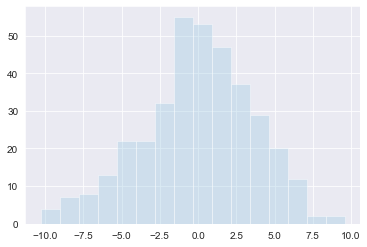

In [30]:
print(len(test_results))
sns.distplot(test_results, kde = False)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x20743c3d400>,
 'caps': [<matplotlib.lines.Line2D at 0x20743c3db00>,
 'boxes': [<matplotlib.lines.Line2D at 0x20743c27f60>],
 'medians': [<matplotlib.lines.Line2D at 0x20743c3de48>],
 'fliers': [<matplotlib.lines.Line2D at 0x20743c4c5c0>],
 'means': []}

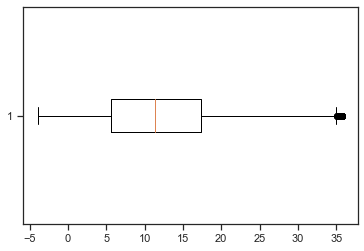

In [10]:
plt.boxplot(mythenquai_1y["air_temperature"], vert = False)

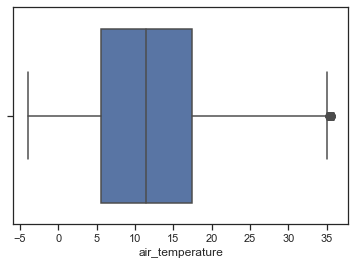

In [11]:
sns.boxplot(x = mythenquai_1y["air_temperature"])

In [88]:
mythenquai_1y_sample = mythenquai_1y[0:10000]
mythenquai_1y_sample_stepped24h = mythenquai_1y[1:50000:144]

In [89]:
time_series_temp = px.line(mythenquai_1y_sample, x = mythenquai_1y_sample["time"], 
                           y = mythenquai_1y_sample["air_temperature"])
time_series_temp.show()

In [113]:
mythenquai_1y_sample["air_temperature"].value_counts(normalize = True, dropna = False)
round(tiefenbrunnen_1y.describe(),1)

,air_temperature,barometric_pressure_qfe,dew_point,humidity,water_temperature,wind_direction,wind_force_avg_10min,wind_gust_max_10min,wind_speed_avg_10min,windchill
count,52535.0,52535.0,52535.0,52535.0,52535.0,52535.0,52535.0,52535.0,52535.0,52535.0
mean,11.9,969.0,7.1,74.7,13.4,133.6,1.0,2.6,1.2,11.2
std,7.7,8.1,6.3,15.4,6.8,113.3,1.1,2.9,1.6,8.1
min,-3.9,940.0,-7.4,19.0,4.7,0.0,0.0,0.0,0.0,-7.2
25%,5.6,964.7,1.9,65.0,6.7,31.0,0.0,0.6,0.0,4.5
50%,11.4,969.2,6.7,77.0,12.1,119.0,1.0,1.8,0.5,10.5
75%,17.4,973.6,12.3,87.0,19.6,215.0,2.0,3.6,1.6,17.2
max,35.8,988.4,23.4,100.0,27.9,360.0,12.4,29.5,12.6,35.9


In [117]:
mythenquai_1d, tiefenbrunnen_1d = select_timedelta(1)

time_series_temp_1d = px.line(mythenquai_1d, x = mythenquai_1d["time"], 
                           y = mythenquai_1d["air_temperature"])
time_series_temp_1d.show()